In [2]:
pip install torch

     |████████████████████████████████| 127.9MB 52kB/s s eta 0:00:01  |                                | 194kB 6.8MB/s eta 0:00:19     |████▌                           | 18.1MB 9.9MB/s eta 0:00:12     |█████▌                          | 21.8MB 12.0MB/s eta 0:00:09     |█████████▋                      | 38.6MB 15.3MB/s eta 0:00:06     |███████████▏                    | 44.7MB 15.3MB/s eta 0:00:06     |████████████                    | 47.8MB 15.3MB/s eta 0:00:06     |█████████████▎                  | 53.2MB 12.7MB/s eta 0:00:06     |█████████████████▎              | 68.9MB 14.0MB/s eta 0:00:05     |███████████████████▍            | 77.3MB 16.7MB/s eta 0:00:04     |████████████████████████▌       | 98.0MB 16.6MB/s eta 0:00:02     |███████████████████████████     | 107.8MB 19.2MB/s eta 0:00:02
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(111)

In [24]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 4 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

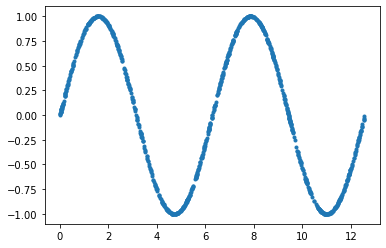

In [25]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [26]:
# DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
#            batch_sampler=None, num_workers=0, collate_fn=None,
#            pin_memory=False, drop_last=False, timeout=0,
#            worker_init_fn=None, *, prefetch_factor=2,
#            persistent_workers=False)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [27]:
# NN for Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [47]:
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [48]:
# Train the GAN

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1)) # torch.ones() to create labels with the value 1 for the real samples
        latent_space_samples = torch.randn((batch_size, 2)) # Noise for generator samples
        generated_samples = generator(latent_space_samples) # Generator samples
        generated_samples_labels = torch.zeros((batch_size, 1)) # Label the generator samples as zero
        all_samples = torch.cat((real_samples, generated_samples)) # Concatenate all the samples
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        ) # Concatenate sample labels

        # Training the discriminator
        discriminator.zero_grad() #In PyTorch, it’s necessary to clear the gradients at each training step to avoid accumulating them
        output_discriminator = discriminator(all_samples) # Calculate the output of the discriminator using the training data in all_samples.
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        
        loss_discriminator.backward() # Calculate the gradients by backward()
        optimizer_discriminator.step() # update the discriminator weights

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad() # clear the gradients 
        generated_samples = generator(latent_space_samples) #Input only the generator samples
        
        output_discriminator_generated = discriminator(generated_samples) # Feed the generator’s output into the discriminator and store its output in output_discriminator_generated
        
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        ) # Calculate loss for generator
        
        loss_generator.backward() # Calculate the gradients by backward()
        optimizer_generator.step() # update the discriminator weights
        latent_space_samples = torch.randn(100, 2)
        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.634308934211731
Epoch: 0 Loss G.: 1.0492727756500244
Epoch: 10 Loss D.: 0.5874106287956238
Epoch: 10 Loss G.: 1.0286537408828735
Epoch: 20 Loss D.: 0.617804229259491
Epoch: 20 Loss G.: 0.9173839688301086
Epoch: 30 Loss D.: 0.49407947063446045
Epoch: 30 Loss G.: 1.2827928066253662
Epoch: 40 Loss D.: 0.6174103617668152
Epoch: 40 Loss G.: 0.9740513563156128
Epoch: 50 Loss D.: 0.5867607593536377
Epoch: 50 Loss G.: 1.0734893083572388
Epoch: 60 Loss D.: 0.5969976782798767
Epoch: 60 Loss G.: 1.1924521923065186
Epoch: 70 Loss D.: 0.5945090651512146
Epoch: 70 Loss G.: 1.7022583484649658
Epoch: 80 Loss D.: 0.5386304259300232
Epoch: 80 Loss G.: 1.0174459218978882
Epoch: 90 Loss D.: 0.5057607293128967
Epoch: 90 Loss G.: 1.2483736276626587
Epoch: 100 Loss D.: 0.6598978042602539
Epoch: 100 Loss G.: 0.9978370070457458
Epoch: 110 Loss D.: 0.5601845979690552
Epoch: 110 Loss G.: 0.9473928213119507
Epoch: 120 Loss D.: 0.6578633189201355
Epoch: 120 Loss G.: 0.9129590392112732
Epoch: 13

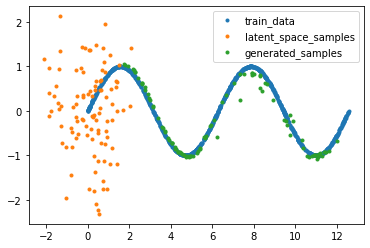

In [51]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(train_data[:, 0], train_data[:, 1], ".",label="train_data")
plt.plot(latent_space_samples[:, 0], latent_space_samples[:, 1], ".",label="latent_space_samples")
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".",label="generated_samples")
plt.legend()